In [1]:
edition_file: str = "yeast_edit.json" # path to a json file that contains editions between graphs
graph_A:str = '/home/sidubois/Data_pangenomes/yeast_graphs/15_indiv_experiment/plain_graph/graph_00.gfa' # "/home/sidubois/Data_pangenomes/yeast_graphs/per_chromosome/mgc/chr_14.gfa"
graph_B:str = '/home/sidubois/Data_pangenomes/yeast_graphs/15_indiv_experiment/plain_graph/pggb_final.gfa' # "/home/sidubois/Data_pangenomes/yeast_graphs/per_chromosome/pggb/chr_14.gfa"
variants_file_A:str = "cactus.vcf" # path to a vcf for graph A
variants_file_B:str = "pggb.vcf" # path to a vcf for graph B
variants_filter_A:str = "cactus.filter.vcf" # path to a vcf for graph A
variants_filter_B:str = "pggb.filter.vcf" # path to a vcf for graph B
private_variants_file_A:str = 'cactus.private.vcf'
private_variants_file_B:str = 'pggb.private.vcf'
reference:list[str] = ['CASBJU01'] # ["CASBIW010000027|CASBIW010000027.1|chrXIV"] # choosing a reference to plot against
chromosom:str = '1' # '14'

In [ ]:
colors:dict[str,str] = {
    'blue':    '#377eb8', 
    'orange':  '#ff7f00',
    'green':   '#4daf4a',
    'pink':    '#f781bf',
    'brown':   '#a65628',
    'purple':  '#984ea3',
    'gray':    '#999999',
    'red':     '#e41a1c',
    'yellow':  '#dede00'
}

In [2]:
from json import load
from matplotlib import pyplot as plt
from numpy import nan
from pgGraphs import Graph
from os import system
from seaborn import regplot
from pandas import DataFrame
from scipy import stats
from itertools import pairwise

# Creating mandatory files to compare graphs

In [3]:
# First, we compute edition to be sure to have a list of breakpoints
system(f'pancat edit {graph_A} {graph_B} -o {edition_file}')

# Then, we compute variants file
system(f'vg deconstruct -e -a -p "{reference[0]}#{reference[0]}" {graph_A} > {variants_file_A}') # format for raw cactus files > "seq000#{reference[0]}"
system(f'vg deconstruct -e -a -p "{reference[0]}" {graph_B} > {variants_file_B}') # format for pggb files

PANCAT initialisation sucessful!
[04/05/2024 02:12:01 PM] Loaded graph /home/sidubois/Data_pangenomes/yeast_graphs/15_indiv_experiment/plain_graph/graph_00.gfa in memory
Paths of Graph_A CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[04/05/2024 02:12:01 PM] Loaded graph /home/sidubois/Data_pangenomes/yeast_graphs/15_indiv_experiment/plain_graph/pggb_final.gfa in memory
Paths of Graph_B CASBIT01, CASBIW01, CASBIZ01, CASBJG01, CASBJH01, CASBJI01, CASBJJ01, CASBJL01, CASBJM01, CASBJN01, CASBJQ01, CASBJS01, CASBJT01, CASBJU01, CASBJV01
[04/05/2024 02:12:01 PM] Computing edition for graphs on single thread
PATH SELECTION: {'CASBIT01', 'CASBJJ01', 'CASBJT01', 'CASBJQ01', 'CASBIW01', 'CASBJH01', 'CASBJG01', 'CASBJL01', 'CASBIZ01', 'CASBJM01', 'CASBJI01', 'CASBJN01', 'CASBJU01', 'CASBJV01', 'CASBJS01'}
[04/05/2024 02:12:01 PM] Saving results in yeast_edit.json
[04/05/2024 02:12:02 PM] Job ter

0

# Loading files in memory

In [4]:
editions:dict[str,list] = load(open(edition_file,'r',encoding='utf-8'))

cactus_gfa:Graph = Graph(graph_A)
pggb_gfa:Graph = Graph(graph_B)

Showing the different path names

In [5]:
cactus_gfa.paths.keys()

dict_keys(['CASBIT01', 'CASBIW01', 'CASBIZ01', 'CASBJG01', 'CASBJH01', 'CASBJI01', 'CASBJJ01', 'CASBJL01', 'CASBJM01', 'CASBJN01', 'CASBJQ01', 'CASBJS01', 'CASBJT01', 'CASBJU01', 'CASBJV01'])

# Performing comparison

First, we will look at the distribution of variants along the graph.
- We need to get the length of the reference sequence for the x-axis of the graph
- Then, we can plot by position the variants from the according vcfs

In [6]:
# We can take any of the two as they have the same content in sequences
reference_length:int = sum([cactus_gfa.segments[x]['length'] for x,_ in cactus_gfa.paths[reference[0].upper()]['path']])
print(f'Length of the reference is {reference_length} bp.')

Length of the reference is 222424 bp.


We open the variants files

In [7]:
file_A_variants:dict[str,tuple] = dict()
with open(variants_file_A,'r') as vcf_A:
    for line in vcf_A:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_A_variants[l[1]]=(l[3],l[4])
            
file_B_variants:dict[str,tuple] = dict()
with open(variants_file_B,'r') as vcf_B:
    for line in vcf_B:
        if not line.startswith('#'):
            l:list[str] = line.split()
            file_B_variants[l[1]]=(l[3],l[4])

We split the variants in batches (percentage of the sequence)

In [8]:
sampling:int = 200

# Comptage des variants dans chacun des graphes (variants totaux)
counts_A:list[int] = [0 for _ in range(sampling)]
counts_B:list[int] = [0 for _ in range(sampling)]
counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
counts_B_sup_50:list[int] = [0 for _ in range(sampling)]

# Comptage des variants privés
p_counts_A:list[int] = [0 for _ in range(sampling)]
p_counts_B:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_2:list[int] = [0 for _ in range(sampling)]
p_counts_A_sup_50:list[int] = [0 for _ in range(sampling)]
p_counts_B_sup_50:list[int] = [0 for _ in range(sampling)]


ratios:float = sampling/reference_length


for pos in file_A_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_A[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_A[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
        counts_A_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_A_sup_2[int(int(pos)*ratios)] += 1

for pos in file_B_variants.keys():
    is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
    counts_B[int(int(pos)*ratios)] += 1
    if not is_common_variant:
        p_counts_B[int(int(pos)*ratios)] += 1
    if any([len(x) >= 50 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_50[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_50[int(int(pos)*ratios)] += 1
    if any([len(x) >= 2 for x in [file_B_variants[pos][0]] + file_B_variants[pos][1].split(',')]):
        counts_B_sup_2[int(int(pos)*ratios)] += 1
        if not is_common_variant:
            p_counts_B_sup_2[int(int(pos)*ratios)] += 1


We plot variations along the reference

Then, we compute editions along the reference. We can only display editions on reference, sadly.

In [9]:
sampling:int = 200
counts_editions:list[int] = [0 for _ in range(sampling)]

counts_merges:list[int] = [0 for _ in range(sampling)]
counts_splits:list[int] = [0 for _ in range(sampling)]
ratios:float = sampling/reference_length

for merge in editions[reference[0].upper()]['merges']:
    counts_editions[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_editions[int(int(split[0])*ratios)] += 1
    
for merge in editions[reference[0].upper()]['merges']:
    counts_merges[int(float(merge[0])*ratios)] += 1

for split in editions[reference[0].upper()]['splits']:
    counts_splits[int(int(split[0])*ratios)] += 1

In [10]:
counts_nodes_cactus:list[int] = [0 for _ in range(sampling)]
counts_nodes_pggb:list[int] = [0 for _ in range(sampling)]

pos_counter: int = 0
for x,_ in cactus_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_cactus[int(float(pos_counter)*ratios)] +=1
    pos_counter += cactus_gfa.segments[x]['length']
    
pos_counter: int = 0
for x,_ in pggb_gfa.paths[reference[0].upper()]['path']:
    counts_nodes_pggb[int(float(pos_counter)*ratios)] +=1
    pos_counter += pggb_gfa.segments[x]['length']

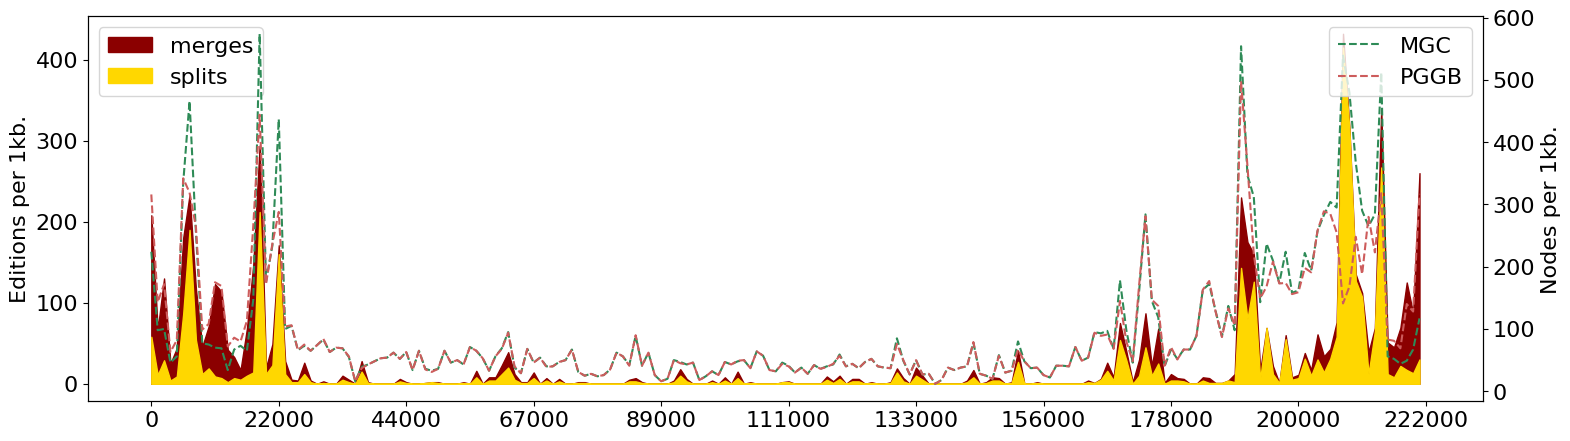

[0,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 22242,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 44485,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 66727,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 88970,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 111212,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 133454,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 155697,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 177939,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 200182,
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',

<Figure size 640x480 with 0 Axes>

In [11]:
from matplotlib import rc

font = {'size': 16}

rc('font', **font)

fig, ax = plt.subplots(figsize=(18,5))
#fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax.fill_between(list(range(sampling)),counts_editions, color= "darkred", label='merges')
ax.fill_between(list(range(sampling)),counts_splits, color= "gold", label='splits')
ax.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
#ax.set_xticklabels([round(__/ratios) if not __%20 else '' for __ in range(sampling)])
ax.legend(loc='upper left')



axb = ax.twinx()
axb.set_ylabel(f'Nodes per {round((reference_length/200)/1000)}kb.')
axb.set_xticks([__ for __ in range(sampling+1) if not __%20])
axb.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])


axb.plot(counts_nodes_cactus,color='seagreen',linestyle='dashed', label='MGC')
axb.plot(counts_nodes_pggb,color='indianred',linestyle='dashed', label='PGGB')
axb.legend(loc='upper right')

plt.savefig("stack_2.png", bbox_inches='tight')
plt.show()
plt.clf()

[round(__/ratios) if not __%20 else '' for __ in range(sampling)]

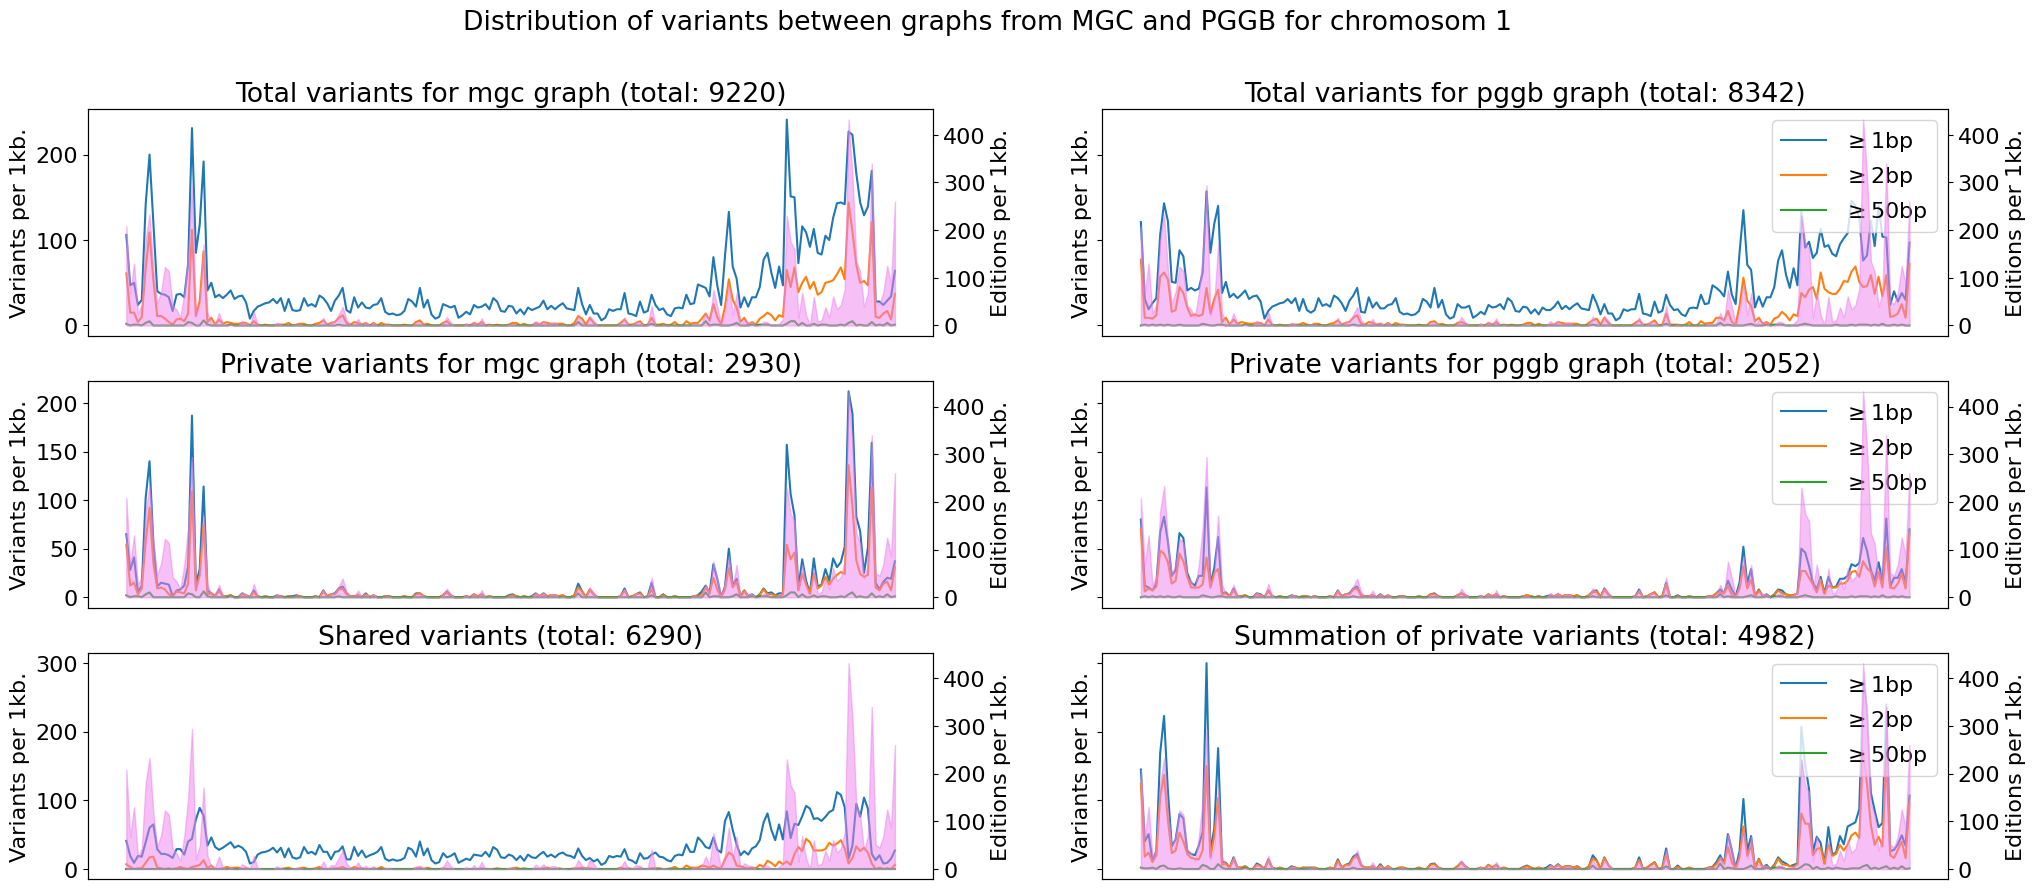

<Figure size 640x480 with 0 Axes>

In [12]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(24,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A)
ax1.plot(counts_A_sup_2)
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B, label='$\geq$1bp')
ax2.plot(counts_B_sup_2, label='$\geq$2bp')
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A)
ax3.plot(p_counts_A_sup_2)
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B, label='$\geq$1bp')
ax4.plot(p_counts_B_sup_2, label='$\geq$2bp')
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)])
ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)])
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp')
ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

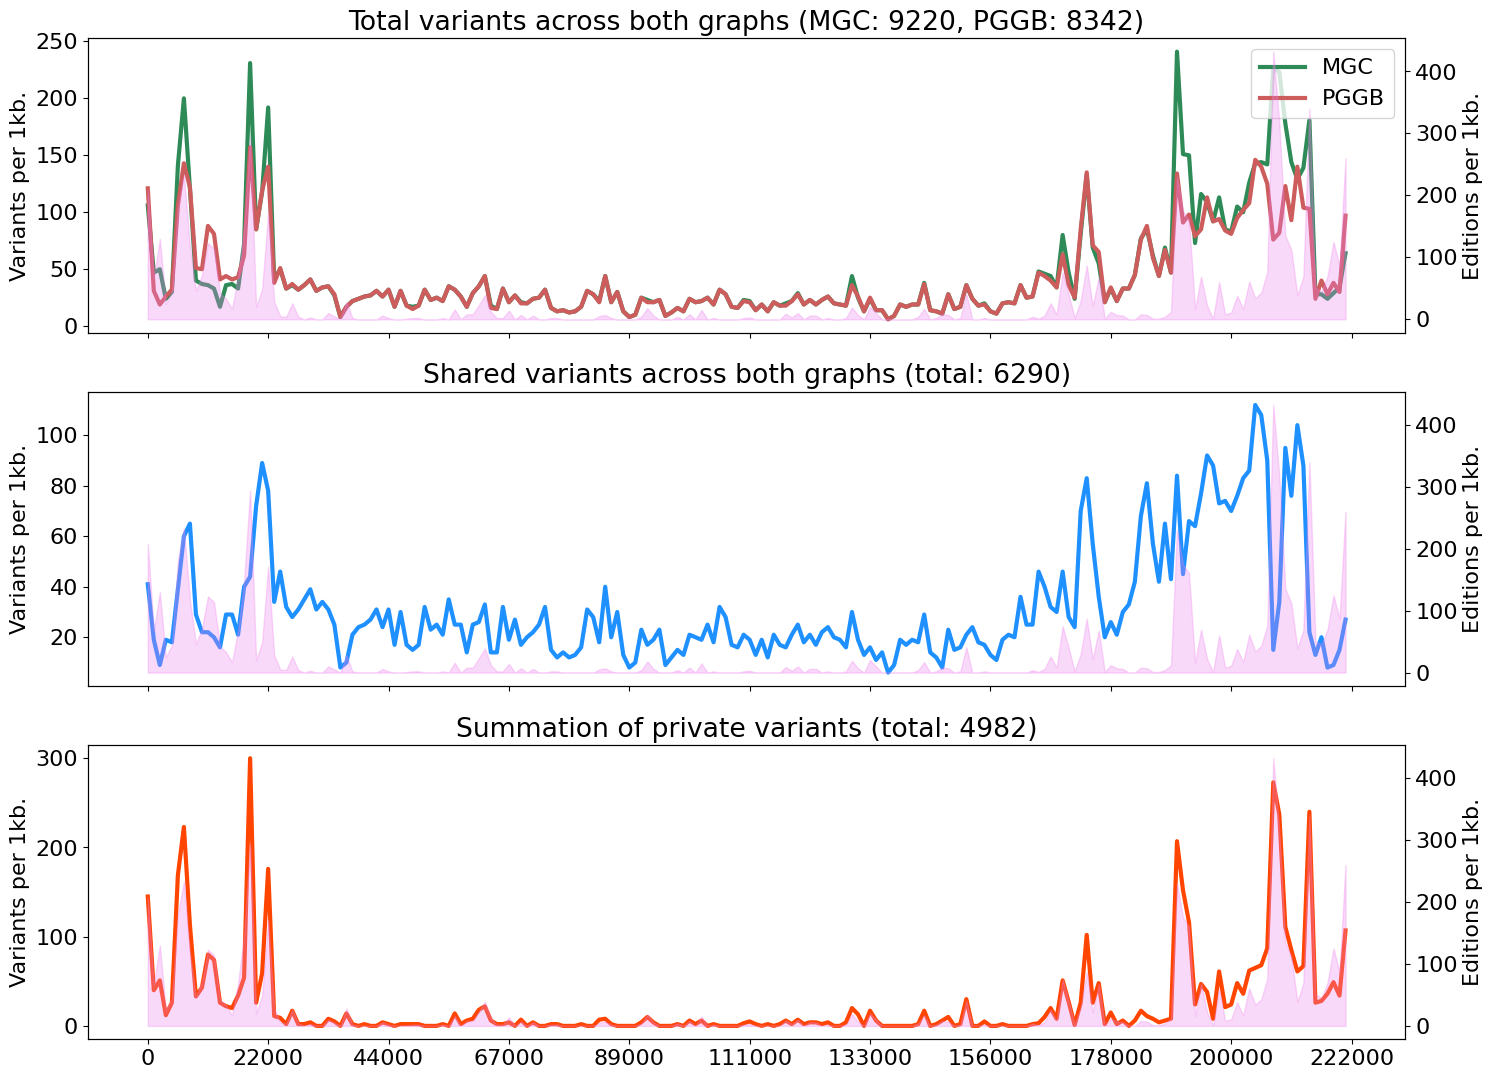

<Figure size 640x480 with 0 Axes>

In [13]:
fig, (ax2, ax5, ax6) = plt.subplots(3,1, sharex=True, sharey='row', figsize=(17,13))

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.3

for axs in (ax2, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha=alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')


ax2.set_title(f"Total variants across both graphs (MGC: {sum(counts_A)}, PGGB: {sum(counts_B)})")
ax2.plot(counts_A, label='MGC', color='seagreen', linewidth=3)
ax2.plot(counts_B, label='PGGB', color='indianred', linewidth=3)

ax2.legend(loc='upper right')

ax5.set_title(f"Shared variants across both graphs (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A[i] - p_counts_A[i] for i in range(sampling)], label='$\geq$1bp', color='dodgerblue', linewidth=3)
#ax5.plot([counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

#ax5.legend(loc='upper right')

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A[i]+ p_counts_B[i] for i in range(sampling)], label='$\geq$1bp', color='orangered', linewidth=3)
#ax6.plot([p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)], label='$\geq$2bp')
#ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')
ax6.set_xticks([__ for __ in range(sampling+1) if not __%20])
ax6.set_xticklabels([int(round(__/ratios,-3)) for __ in range(sampling+1) if not __%20 ])

#ax6.legend(loc='upper right')

plt.savefig("baseline_profile_supp.png", bbox_inches='tight')
plt.show()
plt.clf()

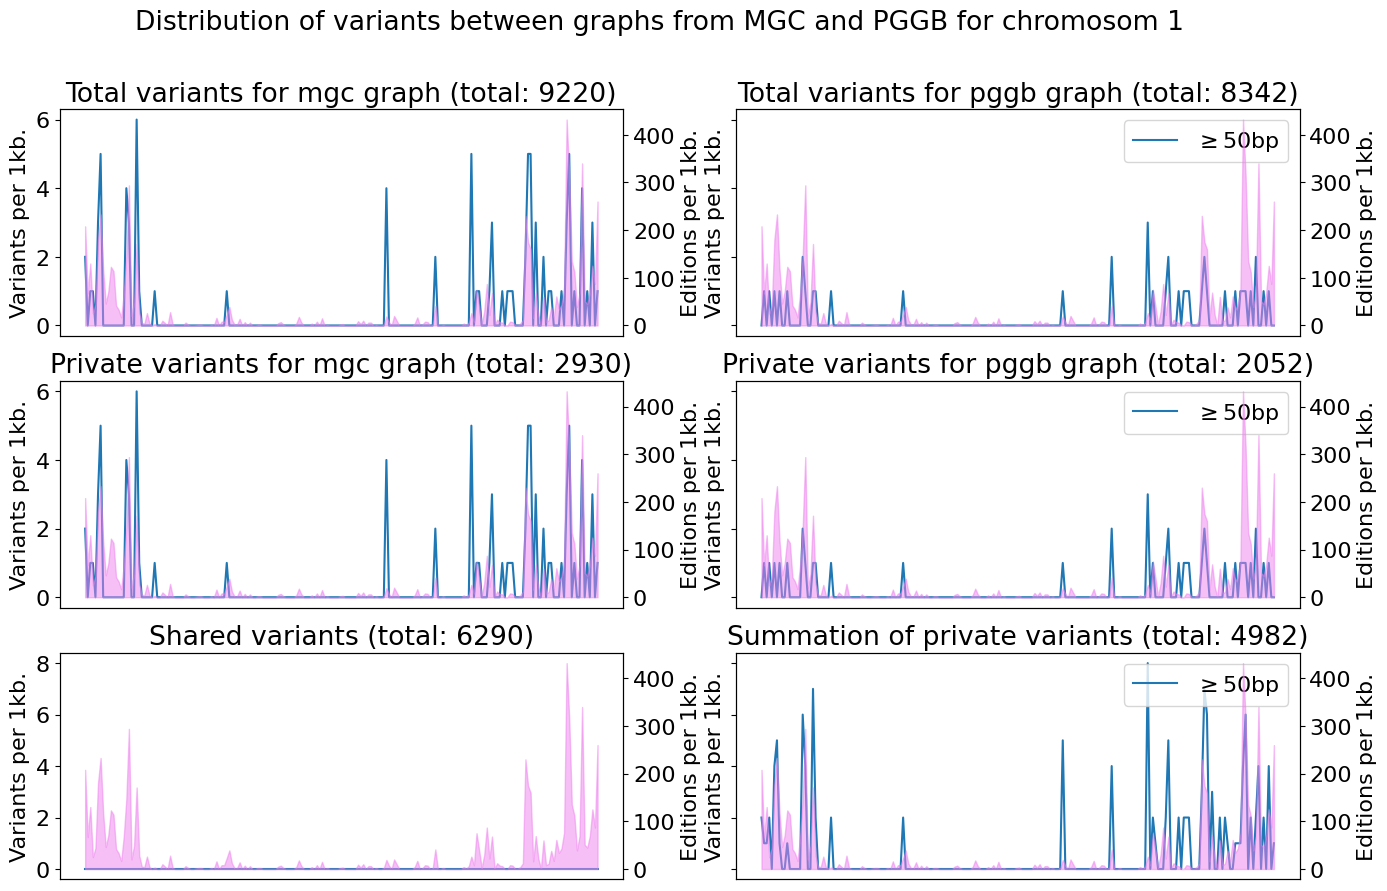

<Figure size 640x480 with 0 Axes>

In [14]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, sharex=True, sharey='row', figsize=(16,10))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4, ax5, ax6):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_sup_50)


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_sup_50, label='$\geq$50bp')

ax2.legend(loc='upper right')

ax3.set_title(f"Private variants for mgc graph (total: {sum(p_counts_A)})")
ax3.plot(p_counts_A_sup_50)

ax4.set_title(f"Private variants for pggb graph (total: {sum(p_counts_B)})")
ax4.plot(p_counts_B_sup_50, label='$\geq$50bp')

ax4.legend(loc='upper right')

ax5.set_title(f"Shared variants (total: {sum(counts_A)-sum(p_counts_A)})")
ax5.plot([counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)])

ax6.set_title(f"Summation of private variants (total: {sum(p_counts_A)+sum(p_counts_B)})")
ax6.plot([p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)], label='$\geq$50bp')

ax6.legend(loc='upper right')

plt.savefig("baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

We build a dataframe

In [15]:
df_ve:DataFrame = DataFrame(
    data={
        'edition_count':counts_editions,
        'full_total':[(counts_A[i]+counts_B[i])/2 for i in range(sampling)],
        'total_variants_mgc':counts_A,
        'total_variants_mgc_sup_2':counts_A_sup_2,
        'total_variants_mgc_sup_50':counts_A_sup_50,
        'private_variants_mgc':p_counts_A,
        'private_variants_mgc_sup_2':p_counts_A_sup_2,
        'private_variants_mgc_sup_50':p_counts_A_sup_50,
        'total_variants_pggb':counts_B,
        'total_variants_pggb_sup_2':counts_B_sup_2,
        'total_variants_pggb_sup_50':counts_B_sup_50,
        'private_variants_pggb':p_counts_B,
        'private_variants_pggb_sup_2':p_counts_B_sup_2,
        'private_variants_pggb_sup_50':p_counts_B_sup_50,
        'shared_variants':[counts_A[i] - p_counts_A[i] for i in range(sampling)],
        'shared_variants_sup_2':[counts_A_sup_2[i] - p_counts_A_sup_2[i] for i in range(sampling)],
        'shared_variants_sup_50':[counts_A_sup_50[i] - p_counts_A_sup_50[i] for i in range(sampling)],
        'private_variants_sum':[p_counts_A[i]+ p_counts_B[i] for i in range(sampling)],
        'private_variants_sum_sup_2':[p_counts_A_sup_2[i]+ p_counts_B_sup_2[i] for i in range(sampling)],
        'private_variants_sum_sup_50':[p_counts_A_sup_50[i] +p_counts_B_sup_50[i] for i in range(sampling)],
        'mgc_nodes':counts_nodes_cactus,
        'pggb_nodes':counts_nodes_pggb,
        'average_nodes':[(counts_nodes_cactus[i]+counts_nodes_pggb[i])/2 for i in range(sampling)]
    }
)

Then we build correlograms

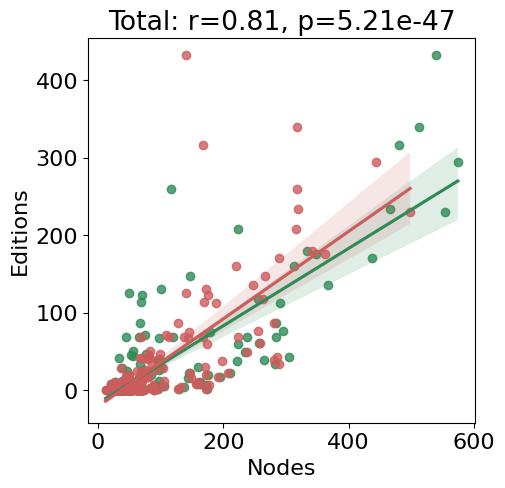

In [16]:
fig, ax = plt.subplots(figsize=(5,5))


ax.set_title(f"Total: r={round(stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['average_nodes'], df_ve['edition_count'])[1]:.2e}")
regplot(x='mgc_nodes', y='edition_count', data=df_ve, ax=ax, color='seagreen')
regplot(x='pggb_nodes', y='edition_count', data=df_ve, ax=ax, color='indianred')
ax.set_ylabel('Editions')
ax.set_xlabel('Nodes')

plt.savefig("correlograms.png", bbox_inches='tight')

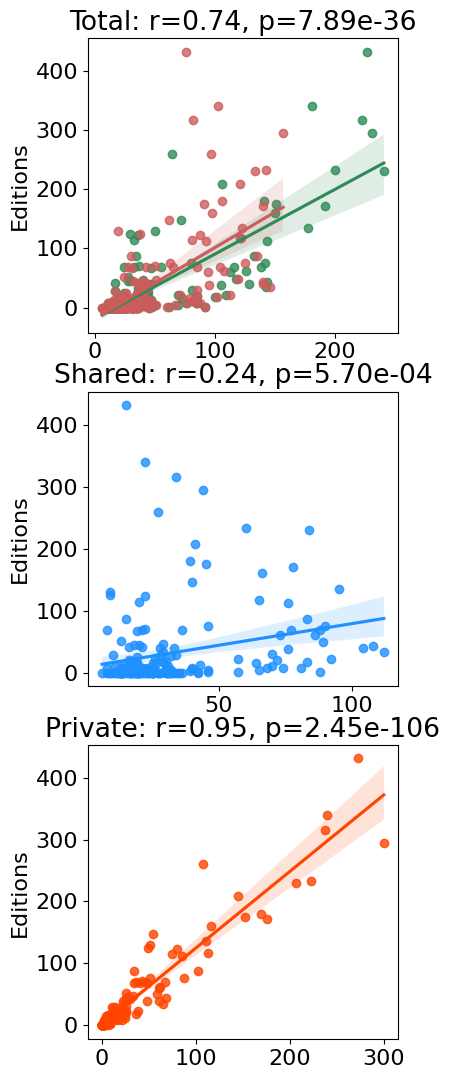

In [25]:
fig, (ax2, ax3, ax4) = plt.subplots(3,1, figsize=(4,13))
#fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")

ax2.set_title(f"Total: r={round(stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['full_total'], df_ve['edition_count'])[1]:.2e}")
regplot(x='total_variants_mgc', y='edition_count', data=df_ve, ax=ax2, color='seagreen')
regplot(x='total_variants_pggb', y='edition_count', data=df_ve, ax=ax2, color='indianred')
ax2.set_ylabel('Editions')
ax2.set_xlabel('')

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3, color='dodgerblue')
#regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
#regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)
ax3.set_ylabel('Editions')
ax3.set_xlabel('')

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4, color='orangered')
#regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
#regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)
ax4.set_ylabel('Editions')
ax4.set_xlabel('')

plt.savefig("correlograms.png", bbox_inches='tight')

<Axes: title={'center': 'Private: r=0.95, p=2.45e-106'}, xlabel='private_variants_sum_sup_50', ylabel='edition_count'>

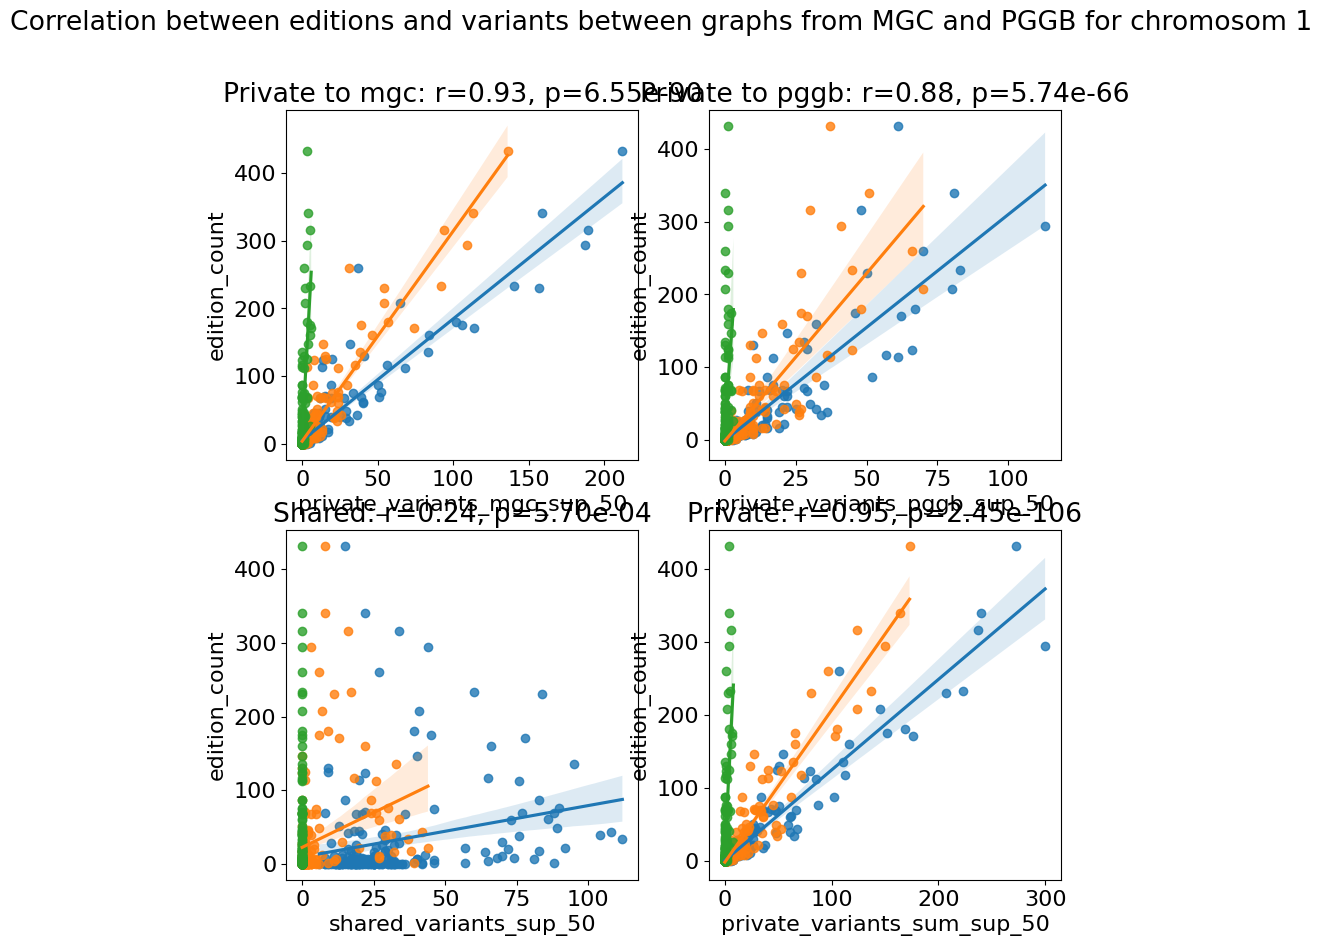

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
fig.suptitle(f"Correlation between editions and variants between graphs from MGC and PGGB for chromosom {chromosom}")


ax1.set_title(f"Private to mgc: r={round(stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_mgc'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_mgc', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_2', y='edition_count', data=df_ve, ax=ax1)
regplot(x='private_variants_mgc_sup_50', y='edition_count', data=df_ve, ax=ax1)

ax2.set_title(f"Private to pggb: r={round(stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_pggb'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_pggb', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_2', y='edition_count', data=df_ve, ax=ax2)
regplot(x='private_variants_pggb_sup_50', y='edition_count', data=df_ve, ax=ax2)

ax3.set_title(f"Shared: r={round(stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['shared_variants'], df_ve['edition_count'])[1]:.2e}")
regplot(x='shared_variants', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_2', y='edition_count', data=df_ve, ax=ax3)
regplot(x='shared_variants_sup_50', y='edition_count', data=df_ve, ax=ax3)

ax4.set_title(f"Private: r={round(stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[0],2)}, p={stats.pearsonr(df_ve['private_variants_sum'], df_ve['edition_count'])[1]:.2e}")
regplot(x='private_variants_sum', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_2', y='edition_count', data=df_ve, ax=ax4)
regplot(x='private_variants_sum_sup_50', y='edition_count', data=df_ve, ax=ax4)

In [19]:
sampling:int = 200

# Comptage des variants dans chacun des graphes (variants totaux)
counts_A_substitutions:list[int] = [0 for _ in range(sampling)]
counts_B_substitutions:list[int] = [0 for _ in range(sampling)]
counts_A_private_substitution:list[int] = [0 for _ in range(sampling)]
counts_B_private_substitution:list[int] = [0 for _ in range(sampling)]

shared_others:list[int] = [0 for _ in range(sampling)]
shared_size_1:list[int] = [0 for _ in range(sampling)]
shared_size_2_9:list[int] = [0 for _ in range(sampling)]
shared_size_10_49:list[int] = [0 for _ in range(sampling)]
shared_size_50:list[int] = [0 for _ in range(sampling)]

ratios:float = sampling/reference_length

with open(private_variants_file_A,'w',encoding='utf-8') as pwriter_A:
    with open(variants_file_A,'r',encoding='utf-8') as reader_A:
        all_lines:list[str] = reader_A.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_A.write(line)
        for pos in file_A_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_A_variants[pos][0]) for x in file_A_variants[pos][1].split(',')]):
                counts_A_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_A_private_substitution[int(int(pos)*ratios)] += 1
            if is_common_variant:
                if all([len(x) == 1 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_1[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 2 and len(x) < 10 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_2_9[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 10 and len(x) < 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_10_49[int(int(pos)*ratios)] += 1
                elif all([len(x) >= 50 for x in [file_A_variants[pos][0]] + file_A_variants[pos][1].split(',')]):
                    shared_size_50[int(int(pos)*ratios)] += 1
                else:
                    # We have a variant with multiple sizes
                    shared_others[int(int(pos)*ratios)] += 1
            else:
                for line in all_lines:
                    if not line.startswith('#'):
                        l:list[str] = line.split()
                        if pos == l[1] and file_A_variants[pos] == (l[3],l[4]):
                            pwriter_A.write(line)
                    
with open(private_variants_file_B,'w',encoding='utf-8') as pwriter_B:
    with open(variants_file_B,'r',encoding='utf-8') as reader_B:
        all_lines:list[str] = reader_B.readlines()
        for line in all_lines:
            if line.startswith('#'):
                pwriter_B.write(line)
        for pos in file_B_variants.keys():
            is_common_variant:bool = file_B_variants.get(pos,None) == file_A_variants.get(pos,None)
            if any([len(x) == len(file_B_variants[pos][0]) for x in file_B_variants[pos][1].split(',')]):
                counts_B_substitutions[int(int(pos)*ratios)] += 1
                if not is_common_variant:
                    counts_B_private_substitution[int(int(pos)*ratios)] += 1
                    for line in all_lines:
                        if not line.startswith('#'):
                            l:list[str] = line.split()
                            if pos == l[1] and file_B_variants[pos] == (l[3],l[4]):
                                pwriter_B.write(line)

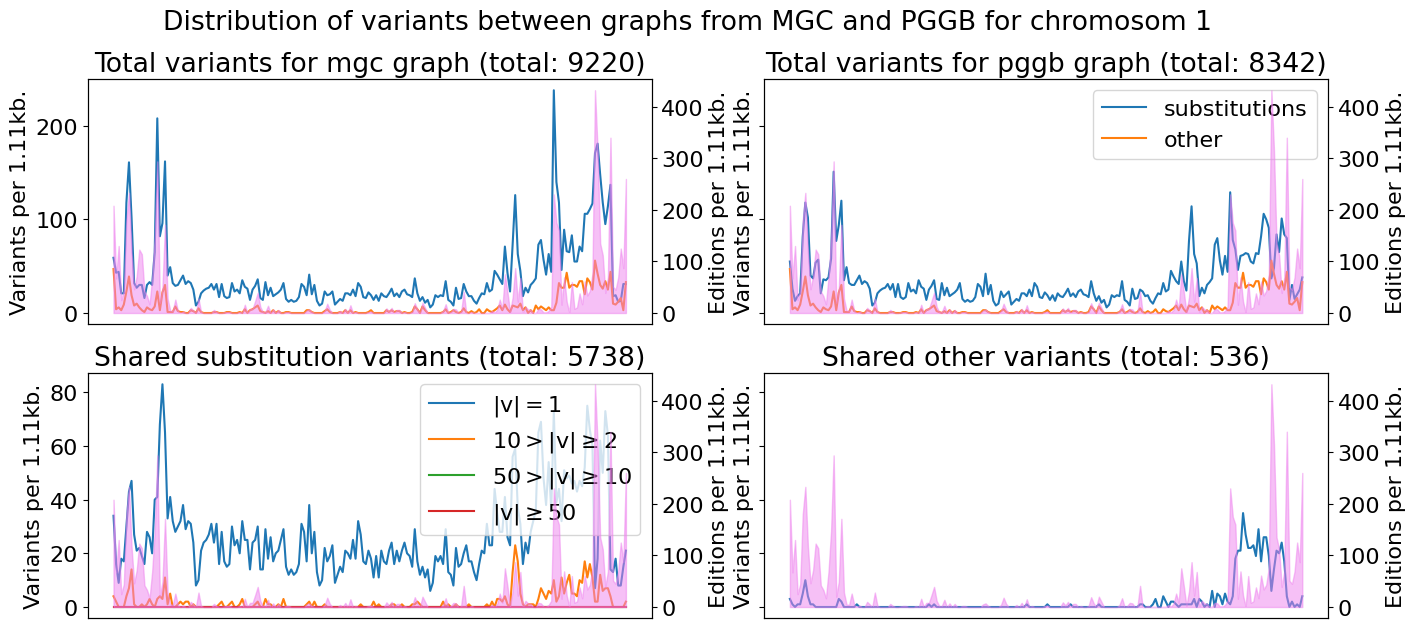

<Figure size 640x480 with 0 Axes>

In [20]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, sharex=True, sharey='row', figsize=(16,7))
fig.suptitle(f"Distribution of variants between graphs from MGC and PGGB for chromosom {chromosom}")

#fig.supylabel(f'Variants per {round((reference_length/200)/1000)}kb.')

alpha = 0.5

for axs in (ax1, ax2, ax3, ax4):
    __ = axs.twinx()
    __.fill_between(list(range(sampling)),counts_editions, color= "violet",alpha= alpha)
    __.set_ylabel(f'Editions per {round((reference_length/200)/1000,2)}kb.')
    axs.set_xticks([])
    axs.set_ylabel(f'Variants per {round((reference_length/200)/1000,2)}kb.')

ax1.set_title(f"Total variants for mgc graph (total: {sum(counts_A)})")
ax1.plot(counts_A_substitutions)
ax1.plot([counts_A[i] - counts_A_substitutions[i] for i in range(sampling)])


ax2.set_title(f"Total variants for pggb graph (total: {sum(counts_B)})")
ax2.plot(counts_B_substitutions, label='substitutions')
ax2.plot([counts_A[i]- counts_A_substitutions[i] for i in range(sampling)], label='other')

ax2.legend(loc='upper right')

# STABLE VARIANTS (shared variants across both graphs)

ax3.set_title(f"Shared substitution variants (total: {sum([counts_A_substitutions[i]- counts_A_private_substitution[i] for i in range(sampling)])})")
ax3.plot(shared_size_1, label='|v|$=$1')
ax3.plot(shared_size_2_9, label='10$>$|v|$\geq$2')
ax3.plot(shared_size_10_49, label='50$>$|v|$\geq$10')
ax3.plot(shared_size_50, label='|v|$\geq$50')

ax3.legend(loc='upper right')

ax4.set_title(f"Shared other variants (total: {sum(shared_others)})")
ax4.plot(shared_others, label='others')

plt.savefig("baseline_profile.png", bbox_inches='tight')
plt.show()
plt.clf()

We filter VCFs

In [21]:

with open(variants_filter_A,'w',encoding='utf-8') as vcfwriter_A:
    with open(variants_file_A,'r') as vcf_A:
        for line in vcf_A:
            if line.startswith('#'):
                vcfwriter_A.write(line)
            else:
                l:list[str] = line.split()
                if any([len(__) >= 50 for __ in [l[3]]+[l[4].split(',')]]):
                    vcfwriter_A.write(f'{line}\n')
            

with open(variants_filter_B,'w',encoding='utf-8') as vcfwriter_B:
    with open(variants_file_B,'r') as vcf_B:
        for line in vcf_B:
            if line.startswith('#'):
                vcfwriter_B.write(line)
            else:
                l:list[str] = line.split()
                if any([len(__) >= 50 for __ in [l[3]]+[l[4].split(',')]]):
                    vcfwriter_B.write(f'{line}\n')

In this part we will try to put in relation edition to variants. 

We will compare editions positions and prefixes to see if we have prefixes that may led to think we have a normalization problem

In [22]:
cactus_gfa.sequence_offsets()

in_bounds:dict[str,list[int]] = dict() # liste de positions de début de noeuds



for path,classes in editions.items():
    for node,data in cactus_gfa.segments.items():
        in_bounds[node] = [x[0] for x in data['PO'].get(path,[])]
        
    sequences_prefixes: list[str] = list()
        
    for (position,(node,)) in classes['splits']:
        in_bound = min(in_bounds[node], key=lambda x:abs(x-position))
        sequences_prefixes.append((cactus_gfa.segments[node]['seq'][0:position-in_bound],node))
        
    # On nettoie les sequences prefixes
        
    
    sequences_prefixes = sorted(sequences_prefixes, key= lambda x:x[0])
    
    chain:list = list()
    
    index_seq:int = 0
    for node in cactus_gfa.paths[path]['path']:
        if sequences_prefixes[index_seq][1] == node:
            elt = sequences_prefixes[index_seq]
        else:
            elt = None
        chain.append(elt)
    
    for a,b in pairwise(chain):
        if a and b:
            (x,n1),(y,n2) = a,b
            if x == y:
                print(f"Implied nodes: {n1}, {n2}")

ValueError: too many values to unpack (expected 1)

Here, no output = no normalization problem (from the standpoint we stood from)


We now need to compare the list of editions to our differing variants. We can already try to match our variants with the variants from the other file.